# Spam classification using Naive Bayes & SVM 

#### This notebook contains source code for Higher Mathematics project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import numpy as np
import seaborn as sns
import time
import re
import warnings 
warnings.filterwarnings("ignore")



In [2]:
from IPython.display import Image
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [3]:
dt = pd.read_csv('emails.csv')

In [4]:
dt.head(10)

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
5,"Subject: great nnews hello , welcome to medzo...",1
6,Subject: here ' s a hot play in motion homela...,1
7,Subject: save your money buy getting this thin...,1
8,Subject: undeliverable : home based business f...,1
9,Subject: save your money buy getting this thin...,1


In [5]:
dt.shape

(5728, 2)

In [6]:
dt.groupby('spam').count()

,text
spam,
0,4360
1,1368


### Spam & Non Spam plot distribution using bar graph 

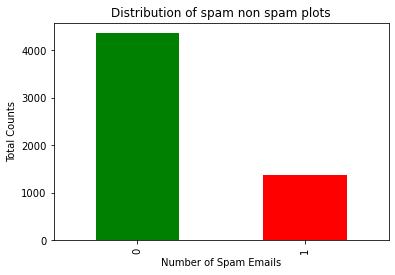

In [7]:
fig, ax = plt.subplots()
count = pd.value_counts(dt["spam"], sort = True)
count.plot(kind = 'bar', color = ["green","red"])
count.plot(kind='bar', color = ["green","red"],ax=ax)
plt.title("Distribution of spam non spam plots")
plt.xlabel('Number of Spam Emails')
plt.ylabel('Total Counts')
#ax.legend(["0 = non-Spam"])
#plt.legend()
plt.show()



### Checking if the length of the email is co related to spam/non spam criteria

In [8]:
dt['length'] = dt['text'].map(lambda text: len(text))
#dt.groupby('spam').length.describe()

In [9]:
dt['length']

0       1484
1        598
2        448
3        500
4        235
        ... 
5723    1189
5724    1167
5725    2131
5726    1060
5727    2331
Name: length, Length: 5728, dtype: int64

In [10]:
dt.groupby('spam').length.describe()

,count,mean,std,min,25%,50%,75%,max
spam,,,,,,,,
0,4360.0,1631.918119,1959.664549,13.0,577.75,1122.0,2037.25,43952.0
1,1368.0,1317.257310,2271.372893,18.0,401.50,693.5,1250.25,28432.0


### Our Email length got some extreme outliers, so we set a length threshold and checking the length distribution

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f1e0ec550>,
      dtype=object)

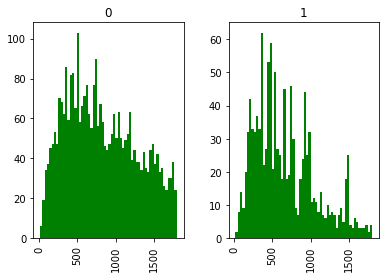

In [11]:
dt_subs = dt[dt.length<1800]
dt_subs.hist(column = 'length', by = 'spam', bins =60, color = 'green')

In [12]:
dt['spam'] = dt['spam'].map({1:'SPAM', 0:'NON-SPAM'}) 

In [13]:
dt['spam'] = dt['spam'].apply(str)


In [14]:
dt.tail()

,text,spam,length
5723,Subject: re : research and development charges...,NON-SPAM,1189
5724,"Subject: re : receipts from visit jim , than...",NON-SPAM,1167
5725,Subject: re : enron case study update wow ! a...,NON-SPAM,2131
5726,"Subject: re : interest david , please , call...",NON-SPAM,1060
5727,Subject: news : aurora 5 . 2 update aurora ve...,NON-SPAM,2331


### Text Analytics before TOKENIZATION

In [15]:
count = Counter(" ".join(dt[dt['spam']=='NON-SPAM']["text"]).split()).most_common(20)
dataframe1 = pd.DataFrame.from_dict(count)
dataframe1 = dataframe1.rename(columns={0: "words in non-spam emails", 1 : "total"})
count2 = Counter(" ".join(dt[dt['spam']=='SPAM']["text"]).split()).most_common(20)
dataframe2 = pd.DataFrame.from_dict(count2)
dataframe2 = dataframe2.rename(columns={0: "words in spam emails", 1 : "total_2"})

In [16]:
dataframe1.tail()

,words in non-spam emails,total
15,for,13510
16,enron,13382
17,ect,11417
18,on,11137
19,is,9618


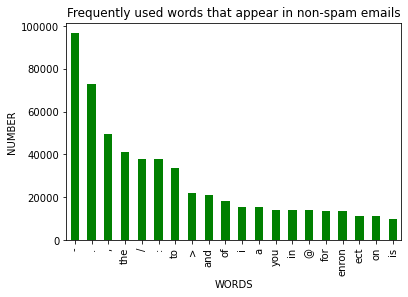

In [17]:
dataframe1.plot.bar(legend = False,color = 'green')
y_pos = np.arange(len(dataframe1["words in non-spam emails"]))
plt.xticks(y_pos, dataframe1["words in non-spam emails"])
plt.title('Frequently used words that appear in non-spam emails')
plt.xlabel('WORDS')
plt.ylabel('NUMBER')
plt.show()

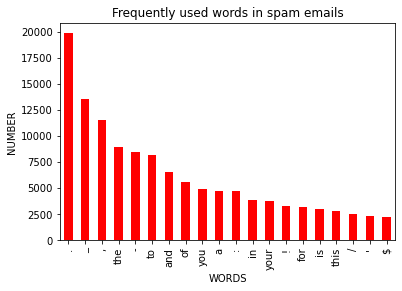

In [18]:
dataframe2.plot.bar(legend = False, color = 'red')
y_pos = np.arange(len(dataframe2["words in spam emails"]))
plt.xticks(y_pos, dataframe2["words in spam emails"])
plt.title('Frequently used words in spam emails')
plt.xlabel('WORDS')
plt.ylabel('NUMBER')
plt.show()

### TOKENIZATION

In [19]:
dt['tokenized'] = dt['text'].map(lambda text: nltk.tokenize.word_tokenize(text))

In [20]:
print(dt['tokenized'])

0       [Subject, :, naturally, irresistible, your, co...
1       [Subject, :, the, stock, trading, gunslinger, ...
2       [Subject, :, unbelievable, new, homes, made, e...
3       [Subject, :, 4, color, printing, special, requ...
4       [Subject, :, do, not, have, money, ,, get, sof...
                              ...                        
5723    [Subject, :, re, :, research, and, development...
5724    [Subject, :, re, :, receipts, from, visit, jim...
5725    [Subject, :, re, :, enron, case, study, update...
5726    [Subject, :, re, :, interest, david, ,, please...
5727    [Subject, :, news, :, aurora, 5, ., 2, update,...
Name: tokenized, Length: 5728, dtype: object


### REMOVING STOP WORDS, SPECIAL CHARACTERS & SUBJECTS

In [21]:
s_words = set(nltk.corpus.stopwords.words('english'))
dt['filtered_text'] = dt['tokenized'].map(lambda tokenized: [word for word in tokenized if not word in s_words])

dt['filtered_text']= dt['filtered_text'].map(lambda text: text[2:])

dt['filtered_text'] = dt['filtered_text'].map(lambda text: ' '.join(text))

dt['filtered_text'] = dt['filtered_text'].map(lambda text: re.sub('[^A-Za-z0-9]+',' ',text))

In [22]:
dt['filtered_text']

0       naturally irresistible corporate identity lt r...
1       stock trading gunslinger fanny merrill muzo co...
2       unbelievable new homes made easy im wanting sh...
3       4 color printing special request additional in...
4       money get software cds software compatibility ...
                              ...                        
5723     research development charges gpg forwarded sh...
5724     receipts visit jim thanks invitation visit ls...
5725     enron case study update wow day super thank m...
5726     interest david please call shirley crenshaw a...
5727    news aurora 5 2 update aurora version 5 2 fast...
Name: filtered_text, Length: 5728, dtype: object

In [23]:
dt.head(5)

,text,spam,length,tokenized,filtered_text
0,Subject: naturally irresistible your corporate...,SPAM,1484,"[Subject, :, naturally, irresistible, your, co...",naturally irresistible corporate identity lt r...
1,Subject: the stock trading gunslinger fanny i...,SPAM,598,"[Subject, :, the, stock, trading, gunslinger, ...",stock trading gunslinger fanny merrill muzo co...
2,Subject: unbelievable new homes made easy im ...,SPAM,448,"[Subject, :, unbelievable, new, homes, made, e...",unbelievable new homes made easy im wanting sh...
3,Subject: 4 color printing special request add...,SPAM,500,"[Subject, :, 4, color, printing, special, requ...",4 color printing special request additional in...
4,"Subject: do not have money , get software cds ...",SPAM,235,"[Subject, :, do, not, have, money, ,, get, sof...",money get software cds software compatibility ...


### LEMMATIZATION

In [24]:
lema = nltk.WordNetLemmatizer()
#nltk.download()


In [25]:
dt['filtered_text'] = dt['filtered_text'].map(lambda text: lema.lemmatize(text))

In [26]:
dt['filtered_text'][9]

'save money buy getting thing tried cialls yet even imagine like real man bed thing great errrectlon provided exactiy want cialis lot advantages viagra effect lasts 36 hours ready start within 10 minutes mix aicohoi ship country get right '

In [52]:
dt.head(10)

,text,spam,length,tokenized,filtered_text
0,Subject: naturally irresistible your corporate...,1,1484,"[Subject, :, naturally, irresistible, your, co...",naturally irresistible corporate identity lt r...
1,Subject: the stock trading gunslinger fanny i...,1,598,"[Subject, :, the, stock, trading, gunslinger, ...",stock trading gunslinger fanny merrill muzo co...
2,Subject: unbelievable new homes made easy im ...,1,448,"[Subject, :, unbelievable, new, homes, made, e...",unbelievable new homes made easy im wanting sh...
3,Subject: 4 color printing special request add...,1,500,"[Subject, :, 4, color, printing, special, requ...",4 color printing special request additional in...
4,"Subject: do not have money , get software cds ...",1,235,"[Subject, :, do, not, have, money, ,, get, sof...",money get software cds software compatibility ...
5,"Subject: great nnews hello , welcome to medzo...",1,478,"[Subject, :, great, nnews, hello, ,, welcome, ...",great nnews hello welcome medzonline sh ground...
6,Subject: here ' s a hot play in motion homela...,1,9340,"[Subject, :, here, ', s, a, hot, play, in, mot...",hot play motion homeland security investments...
7,Subject: save your money buy getting this thin...,1,446,"[Subject, :, save, your, money, buy, getting, ...",save money buy getting thing tried cialls yet ...
8,Subject: undeliverable : home based business f...,1,507,"[Subject, :, undeliverable, :, home, based, bu...",undeliverable home based business grownups mes...
9,Subject: save your money buy getting this thin...,1,446,"[Subject, :, save, your, money, buy, getting, ...",save money buy getting thing tried cialls yet ...


### We'll create WORDCLOUD of spam & non-spam emails

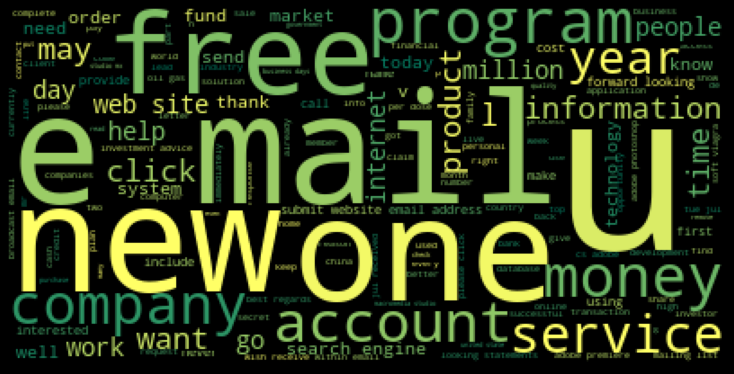

In [27]:
sp_word = ''.join(list(dt[dt['spam']== 'SPAM']['filtered_text']))
sp_wcloud = WordCloud(width = 400, height = 200,random_state=2,  colormap='summer',).generate(sp_word)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(sp_wcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

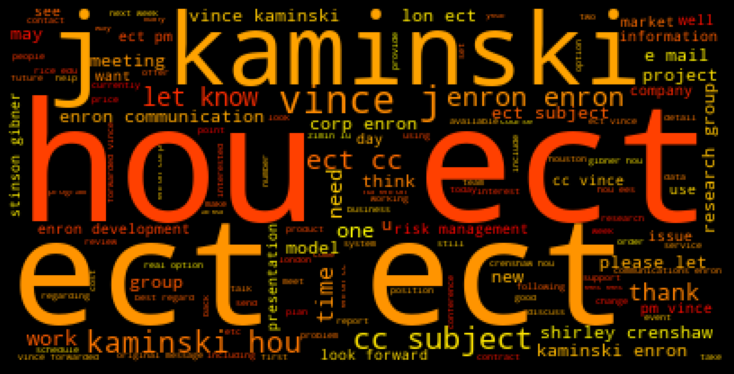

In [28]:
sp_word = ''.join(list(dt[dt['spam']== 'NON-SPAM']['filtered_text']))
sp_wcloud = WordCloud(width = 400, height = 200,random_state=2,  colormap='autumn',).generate(sp_word)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(sp_wcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### Bag of Words

In [29]:
bag = CountVectorizer()
count = bag.fit_transform(dt['filtered_text'].values)

In [30]:
print(count.shape)

(5728, 37158)


### TF-IDF

In [31]:
tfidf_vectorizer = TfidfTransformer().fit(count)
tfidf = tfidf_vectorizer.transform(count)

In [32]:
classifier = MultinomialNB()
targets = dt['spam'].values
classifier.fit(count, targets)

MultinomialNB()

In [33]:
print(tfidf)

  (0, 36494)	0.06909969862066065
  (0, 36361)	0.06758050177560837
  (0, 36359)	0.0596882190240676
  (0, 35954)	0.13195884687352108
  (0, 34965)	0.052342045903568585
  (0, 34731)	0.0938569785598016
  (0, 33491)	0.06922230324784197
  (0, 32967)	0.09491736727758139
  (0, 32775)	0.06074580071568714
  (0, 32549)	0.11154173247342794
  (0, 32534)	0.1196379573681351
  (0, 32252)	0.1196379573681351
  (0, 32196)	0.07897017578675673
  (0, 31901)	0.11852622471547422
  (0, 31892)	0.08500621505740441
  (0, 31481)	0.10455724023138163
  (0, 30158)	0.04608064372595012
  (0, 29798)	0.09335029857939502
  (0, 28818)	0.07692922620869343
  (0, 28205)	0.09214520050901033
  (0, 28049)	0.11016292660431957
  (0, 27925)	0.06592853454480324
  (0, 27166)	0.07329840924511424
  (0, 27165)	0.05762396774659246
  (0, 27063)	0.11083853780061895
  :	:
  (5727, 9123)	0.04914748619287451
  (5727, 8833)	0.04088229823772949
  (5727, 8587)	0.06353438798779128
  (5727, 8305)	0.030885436681033534
  (5727, 8182)	0.04106388086944

In [34]:
examples = ['Free Offer!! Buy now',"Million dollar Lottery","Please send the attachments"]
example_counts = bag.transform(examples)
example_tfidf = tfidf_vectorizer.transform(example_counts)
predictions_tfidf = classifier.predict(example_tfidf)

print(predictions_tfidf)

['SPAM' 'SPAM' 'NON-SPAM']


### Naive Bayes Classifier

In [35]:
feat = feature_extraction.text.CountVectorizer(stop_words = 'english')
x = feat.fit_transform(dt["text"])
np.shape(x)

(5728, 36996)

In [36]:
dt["spam"]=dt["spam"].map({'SPAM':1,'NON-SPAM':0})
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, dt['spam'], test_size=0.33, random_state=42)
print([np.shape(x_train), np.shape(x_test)])

[(3837, 36996), (1891, 36996)]


In [37]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(x_train, y_train)
    score_train[count] = bayes.score(x_train, y_train)
    score_test[count]= bayes.score(x_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(x_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(x_test))
    count = count + 1 


In [38]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['Alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,Alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.999739,0.981491,0.941176,0.987234
1,0.11001,0.998958,0.989952,0.987830,0.974000
2,0.22001,0.998958,0.988895,0.987830,0.970120
3,0.33001,0.998436,0.988366,0.987830,0.968191
4,0.44001,0.998176,0.988366,0.987830,0.968191
5,0.55001,0.997654,0.988366,0.987830,0.968191
6,0.66001,0.997394,0.988366,0.987830,0.968191
7,0.77001,0.997133,0.987837,0.987830,0.966270
8,0.88001,0.996873,0.988366,0.987830,0.968191
9,0.99001,0.996612,0.988366,0.987830,0.968191


In [39]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

Alpha             19.030010
Train Accuracy     0.897055
Test Accuracy      0.870439
Test Recall        0.503043
Test Precision     1.000000
Name: 173, dtype: float64

In [40]:
models[models['Test Precision']==1].head(n=5)

,Alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
173,19.03001,0.897055,0.870439,0.503043,1.0
174,19.14001,0.896794,0.869910,0.501014,1.0
175,19.25001,0.896534,0.868324,0.494929,1.0
176,19.36001,0.896013,0.867266,0.490872,1.0
177,19.47001,0.896013,0.867266,0.490872,1.0


In [41]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(x_train, y_train)
models.iloc[best_index, :]

Alpha             19.030010
Train Accuracy     0.897055
Test Accuracy      0.870439
Test Recall        0.503043
Test Precision     1.000000
Name: 173, dtype: float64

### CONFUSION MATRIX with naive bayes

In [42]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(x_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1398,0
Actual 1,245,248


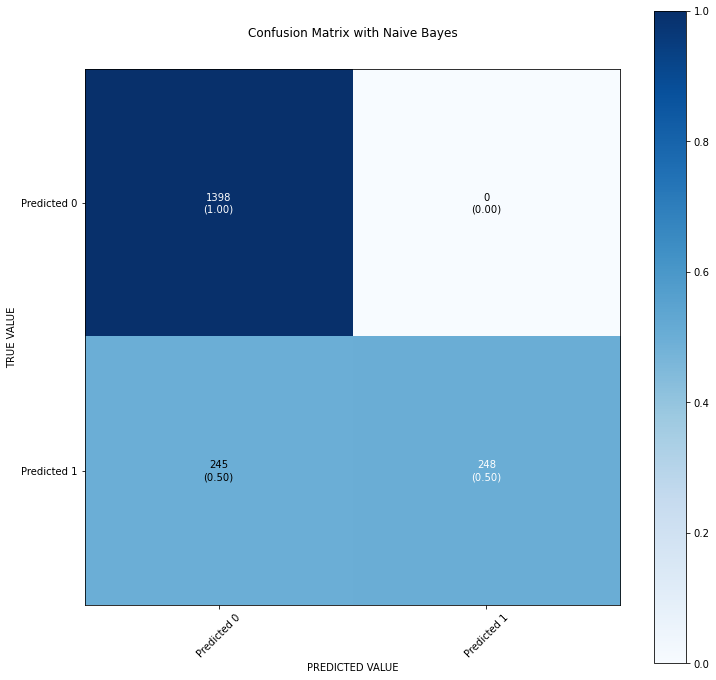

In [43]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
clss = ['Predicted 0', 'Predicted 1']

fig, ax = plot_confusion_matrix(conf_mat = m_confusion_test,
                                figsize = (12,12), 
                                show_absolute = True, show_normed = True
                               , colorbar = True,class_names = clss, hide_ticks = False  )
ax.set_xlabel('PREDICTED VALUE')
ax.set_ylabel('TRUE VALUE')



plt.title("Confusion Matrix with Naive Bayes")
plt.show()

#### we've classified 245 spam as non spam emails and we haven't misclassify any non spam emails

### Support vector machine

In [44]:
list_C = np.arange(500, 2000, 100) #100000
score_train = np.zeros(len(list_C))
score_test = np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))
count = 0
for C in list_C:
    svc = svm.SVC(C=C)
    svc.fit(x_train, y_train)
    score_train[count] = svc.score(x_train, y_train)
    score_test[count]= svc.score(x_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, svc.predict(x_test))
    precision_test[count] = metrics.precision_score(y_test, svc.predict(x_test))
    count = count + 1 

In [45]:
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head()

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,1.0,0.978847,0.93712,0.980892
1,600.0,1.0,0.978847,0.93712,0.980892
2,700.0,1.0,0.978847,0.93712,0.980892
3,800.0,1.0,0.978847,0.93712,0.980892
4,900.0,1.0,0.978847,0.93712,0.980892


In [46]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

C                 500.000000
Train Accuracy      1.000000
Test Accuracy       0.978847
Test Recall         0.937120
Test Precision      0.980892
Name: 0, dtype: float64

In [47]:
models[models['Test Precision']==0.980892]

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision


In [48]:
best_index = models['Test Accuracy'].idxmax()
svc = svm.SVC(C=list_C[best_index])
svc.fit(x_train, y_train)
models.iloc[best_index, :]

C                 500.000000
Train Accuracy      1.000000
Test Accuracy       0.978847
Test Recall         0.937120
Test Precision      0.980892
Name: 0, dtype: float64

### CONFUSION MATRIX for SVM

In [49]:
m_confusion_test = metrics.confusion_matrix(y_test, svc.predict(x_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1389,9
Actual 1,31,462


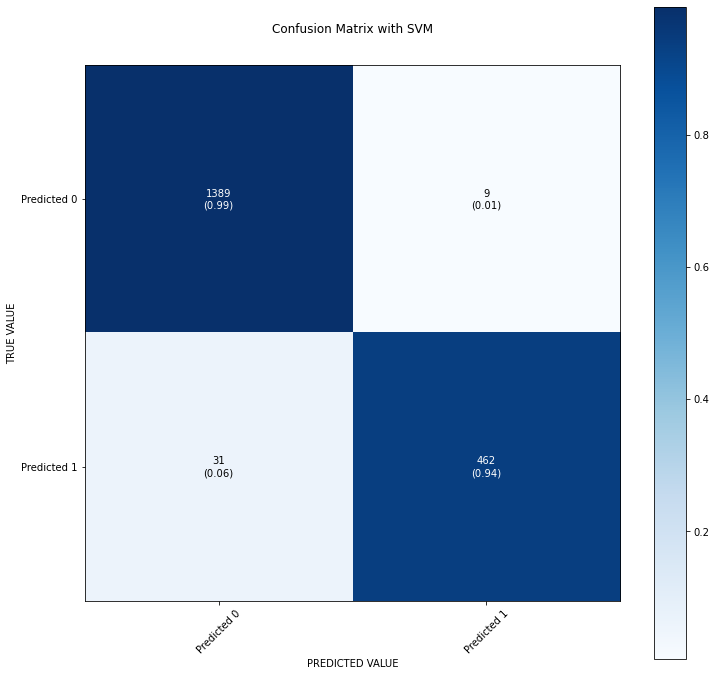

In [50]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
clss = ['Predicted 0', 'Predicted 1']

fig, ax = plot_confusion_matrix(conf_mat = m_confusion_test,
                                figsize = (12,12), 
                                show_absolute = True, show_normed = True
                               , colorbar = True,class_names = clss, hide_ticks = False  )
ax.set_xlabel('PREDICTED VALUE')
ax.set_ylabel('TRUE VALUE')



plt.title("Confusion Matrix with SVM")
plt.show()

#### Here we've misclassified 31 spam as non spam and 9 non spam as spam emails 

                                 -----END-----